# Churn predictive modelling using Apache Spark (PySpark) with Sparkify dataset

This project sets to create a predictive model for churn prediction of a music streaming service: Sparkify. 

Two dataset are made available, a tiny set of 128Mb and a full dataset of 12Gb. 
The project will train the tiny dataset on a local machine to get a sense of the sample data before deciding the components necessary to model on the full dataset. 

Aside from data ecxploration, the local modelling work will find out how to preprocess the data, what features to select and the suitable learning algorithm to adopt. Doing so will make the modelling work more time and computationally efficient. 

For modelling work on the large dataset, AWS EMR cluster will be adopted to do the final training and modelling work. We will also compare to see if full dataset behaves simialrly as well as descriptively similar to the tiny dataset. As such our choice for training features and learning algorithm are wise. 


# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

##### import libraries

In [117]:
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from time import time

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import avg, col, count, stddev, udf, isnan, when, isnull, mean, min, max, skewness, kurtosis
from pyspark.sql.types import IntegerType, BooleanType, DateType
from pyspark.sql.functions import max as max_fn
from pyspark.sql.functions import min as min_fn
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, \
RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegressionModel, \
RandomForestClassificationModel, GBTClassificationModel, DecisionTreeClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [118]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

I am able to obtain the medium dataset and is onyl ~240Mb and will use that instead. 

In [119]:
# Read smaller dataset for analysis
event_data = "./data/tiny_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



##### Number of data points in the dataset

In [12]:
df.count()

543705

##### A brief description of the dataset

In [9]:
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

In [151]:
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

### Missing Values

In [22]:
for col in df.columns:
    missing_count = df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

artist: 110828
firstName: 15700
gender: 15700
lastName: 15700
length: 110828
location: 15700
registration: 15700
song: 110828
userAgent: 15700
userId: 15700


#### Remove rows with missing values in userId and sessionId

In [46]:
print("Number of rows in the Pyspark dataframe: {}".format(df.count()))

Number of rows in the Pyspark dataframe: 543705


In [120]:
df_cleaned = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_cleaned = df_cleaned.filter(df["userId"] != "") # `userId` should not be empty string

In [176]:
print("Number of rows after clearning: {}".format(df_cleaned.count()))

Number of rows after clearning: 528005


In [177]:
if df.count() == df_cleaned.count():
    print("There is no missing values in userId and sessionId")
else:
    print("{} rows removed.".format(df.count() - df_cleaned.count()))

15700 rows removed.


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [179]:
numerical_cols = []
categorical_cols = []

for s in df_cleaned.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        categorical_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        numerical_cols.append(s.name)

### Investigate categorical columns

In [180]:
for c in categorical_cols: 
    print("{} count: {}".format(c, df_cleaned.select(c).count()))

artist count: 528005
auth count: 528005
firstName count: 528005
gender count: 528005
lastName count: 528005
level count: 528005
location count: 528005
method count: 528005
page count: 528005
song count: 528005
userAgent count: 528005
userId count: 528005


### Investigate numerical columns

In [656]:
for n in numerical_cols: 
    print("{} count: {}".format(n, df_cleaned.select(n).count()))
    df_cleaned.select([min(n), max(n), mean(n), stddev(n)]).show()

itemInSession count: 528005
+------------------+------------------+------------------+--------------------------+
|min(itemInSession)|max(itemInSession)|avg(itemInSession)|stddev_samp(itemInSession)|
+------------------+------------------+------------------+--------------------------+
|                 0|              1005|107.77899451709737|        116.86478662969967|
+------------------+------------------+------------------+--------------------------+

length count: 528005
+-----------+-----------+------------------+-------------------+
|min(length)|max(length)|       avg(length)|stddev_samp(length)|
+-----------+-----------+------------------+-------------------+
|    0.78322| 3024.66567|248.66459278007508|  98.41266955052019|
+-----------+-----------+------------------+-------------------+

registration count: 528005
+-----------------+-----------------+--------------------+-------------------------+
|min(registration)|max(registration)|   avg(registration)|stddev_samp(registration

### Investigate every column

In [632]:
df_cleaned.select("artist").distinct().count()

21248

In [89]:
df_cleaned.select("auth").distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [633]:
df_cleaned.select("firstName").distinct().count()

345

In [92]:
df_cleaned.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [634]:
df_cleaned.select("itemInSession").distinct().count()

1006

In [635]:
df_cleaned.select("lastName").distinct().count()

275

In [636]:
df_cleaned.select("length").distinct().count()

16680

In [93]:
df_cleaned.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [637]:
df_cleaned.select("location").distinct().count()

192

In [154]:
df_cleaned.select("location").distinct().show(20)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|        Richmond, VA|
|          Tucson, AZ|
|       Oskaloosa, IA|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|         Medford, OR|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|          Mobile, AL|
|         Dubuque, IA|
|Las Vegas-Henders...|
|  Killeen-Temple, TX|
|     Ottawa-Peru, IL|
|      Boise City, ID|
|Bremerton-Silverd...|
+--------------------+
only showing top 20 rows



In [638]:
df_cleaned.select("method").distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [639]:
df_cleaned.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [641]:
df_cleaned.select("registration").distinct().count()

448

In [643]:
df_cleaned.select("sessionId").distinct().count()

4470

In [645]:
df_cleaned.select("song").distinct().count()

80293

In [323]:
df_cleaned.select("status").distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [646]:
df_cleaned.select("userAgent").distinct().show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


In [647]:
df_cleaned.select("userId").distinct().count()

448

### Define Churn

Cancellation confirmation is adopted to define churn.

##### Number of cancellations:

In [121]:
df_cleaned.filter(df_cleaned.page=="Cancellation Confirmation").select("userId").dropDuplicates().count()


99

In [122]:
churn_list = df_cleaned.filter(df_cleaned.page=="Cancellation Confirmation" ).select("userId").dropDuplicates()
churned_users = [(row['userId']) for row in churn_list.collect()]
df_churn = df_cleaned.withColumn("churn", df_cleaned.userId.isin(churned_users))
df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()


+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     F|  153|
|false|     M|  196|
| true|     M|   54|
| true|     F|   45|
+-----+------+-----+



### Investigate data distribution for churn and non-churn status

Some visualizations of the dataset characteristics across all columns especially on churn and non-churn perspective. Visualization is particularly useful for getting a sense of data skewness on labels and columns that will be used for feature generation. 

#### Churn true/false count with user gender

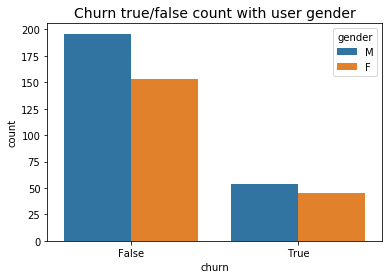

In [44]:
df_churn_pd = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_churn_pd)
plt.title("Churn true/false count with user gender", fontsize=14)
plt.savefig("./plots/churn_gender.png")
plt.show()

#### User subscription level count with gender

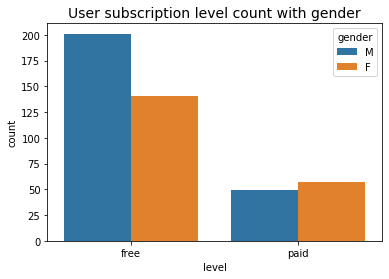

In [45]:
df_level_pd = df_churn.dropDuplicates(["userId", "gender"]).groupby(["gender", "level"]).count().toPandas()
sns.barplot(x='level', y='count', hue='gender', data=df_level_pd)
plt.title("User subscription level count with gender", fontsize=14)
plt.savefig("./plots/level_gender.png")
plt.show()

#### Churn true/false count with subscription level

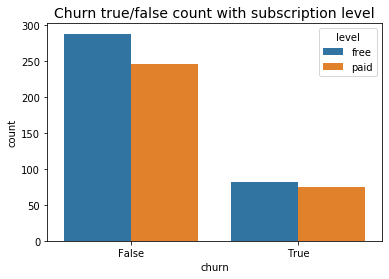

In [46]:
df_churn_level_pd = df_churn.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='level', data=df_churn_level_pd)
plt.title("Churn true/false count with subscription level", fontsize=14)
plt.savefig("./plots/churn_level.png")
plt.show()

As we see the data is rather skewed, with most data points are non-churn. When we use churn as label, skewness should be taken note when it comes training model and metric decision. Similarly, "Level" and "Gender" are skewed too. 

#### User count by weekday with churn status

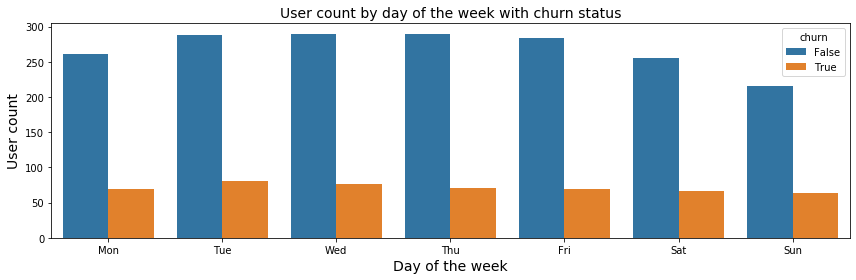

In [79]:
weekday_fn = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_churn = df_churn.withColumn("weekday", weekday_fn(df_churn.ts))
df_churn_weekday_pd = df_churn.dropDuplicates(["userId", "weekday"]).groupby(["weekday", "churn"]).count().sort("weekday").toPandas()
fig = plt.figure(figsize=(12, 4))
sns.barplot(x='weekday', y='count', hue='churn', data=df_churn_weekday_pd)
plt.title("User count by day of the week with churn status", fontsize=14)
plt.xlabel("Day of the week", fontsize=14)
plt.ylabel("User count", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.savefig("./plots/user_weekly_churn.png")
plt.show()

#### Page visit by weekday with churn status

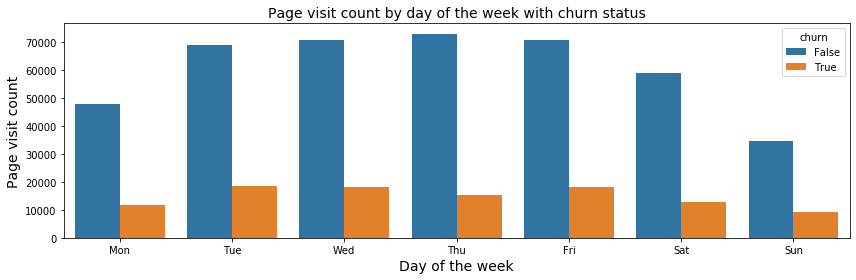

In [78]:
df_churned_week_pd = df_churn.groupby(["weekday", "churn"]).count().sort("weekday").toPandas()
fig = plt.figure(figsize=(12, 4))
sns.barplot(x='weekday', y='count', hue='churn', data=df_churned_week_pd)
plt.title("Page visit count by day of the week with churn status", fontsize=14)
plt.xlabel("Day of the week", fontsize=14)
plt.ylabel("Page visit count", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.savefig("./plots/page_weekday_churn.png")
plt.show()

#### User count by the hour with user churn

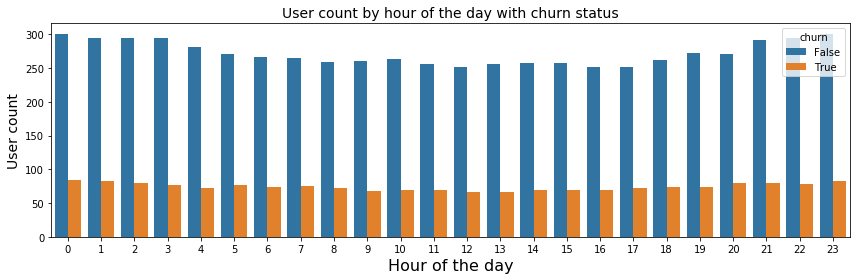

In [73]:
hour_fn = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_churn = df_churn.withColumn("hour", hour_fn(df_churn.ts))
df_churn_hour_pd = df_churn.dropDuplicates(["userId", "hour"]).groupby(["hour", "churn"]).count().sort("hour").toPandas()
fig = plt.figure(figsize=(12, 4))
sns.barplot(x='hour', y='count', hue='churn', data=df_churn_hour_pd)
plt.title("User count by hour of the day with churn status", fontsize=14)
plt.xlabel("Hour of the day", fontsize=16)
plt.ylabel("User count", fontsize=14)
plt.tight_layout()
plt.savefig("./plots/user_hourly_churn.png")
plt.show()

#### Page visit count by the hour with user churn

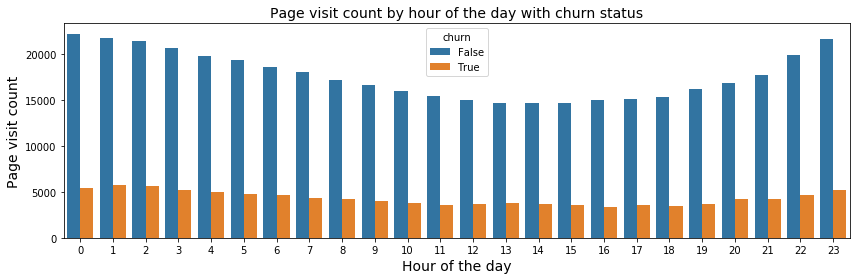

In [72]:
df_churned_hour_pd = df_churn.groupby(["hour", "churn"]).count().sort("hour").toPandas()
fig = plt.figure(figsize=(12, 4))
sns.barplot(x='hour', y='count', hue='churn', data=df_churned_hour_pd)
plt.title("Page visit count by hour of the day with churn status", fontsize=14)
plt.xlabel("Hour of the day", fontsize=14)
plt.ylabel("Page visit count", fontsize=14)
plt.tight_layout()
plt.savefig("./plots/page_hourly_churn.png")
plt.show()

#### Every page visit count with user subscription level

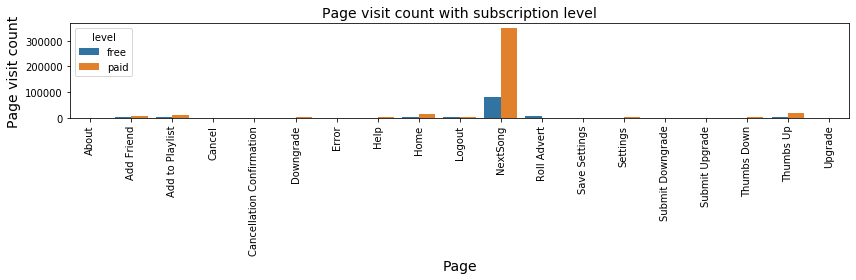

In [71]:
df_churned_page_pd = df_churn.groupby(["page", "level"]).count().sort("page").toPandas()
fig = plt.figure(figsize=(12, 4))
sns.barplot(x='page', y='count', hue='level', data=df_churned_page_pd)
plt.title("Page visit count with subscription level", fontsize=14)
plt.xlabel("Page", fontsize=14)
plt.ylabel("Page visit count", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("./plots/page_visit_level.png")
plt.show()

#### Every page visit count with user gender

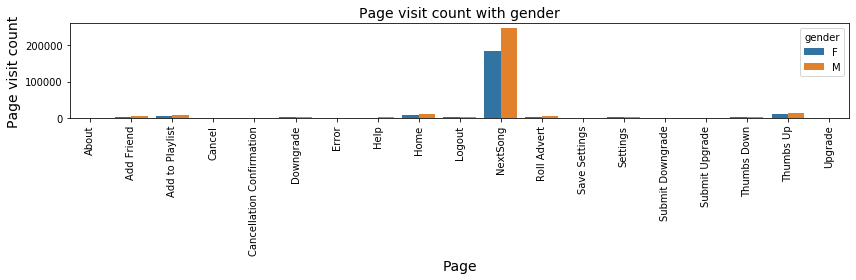

In [70]:
df_churned_page_pd = df_churn.groupby(["page", "gender"]).count().sort("page").toPandas()
fig = plt.figure(figsize=(12, 4))
sns.barplot(x='page', y='count', hue='gender', data=df_churned_page_pd)
plt.title("Page visit count with gender", fontsize=14)
plt.xlabel("Page", fontsize=14)
plt.ylabel("Page visit count", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("./plots/page_visit_gender.png")
plt.show()

#### User by location

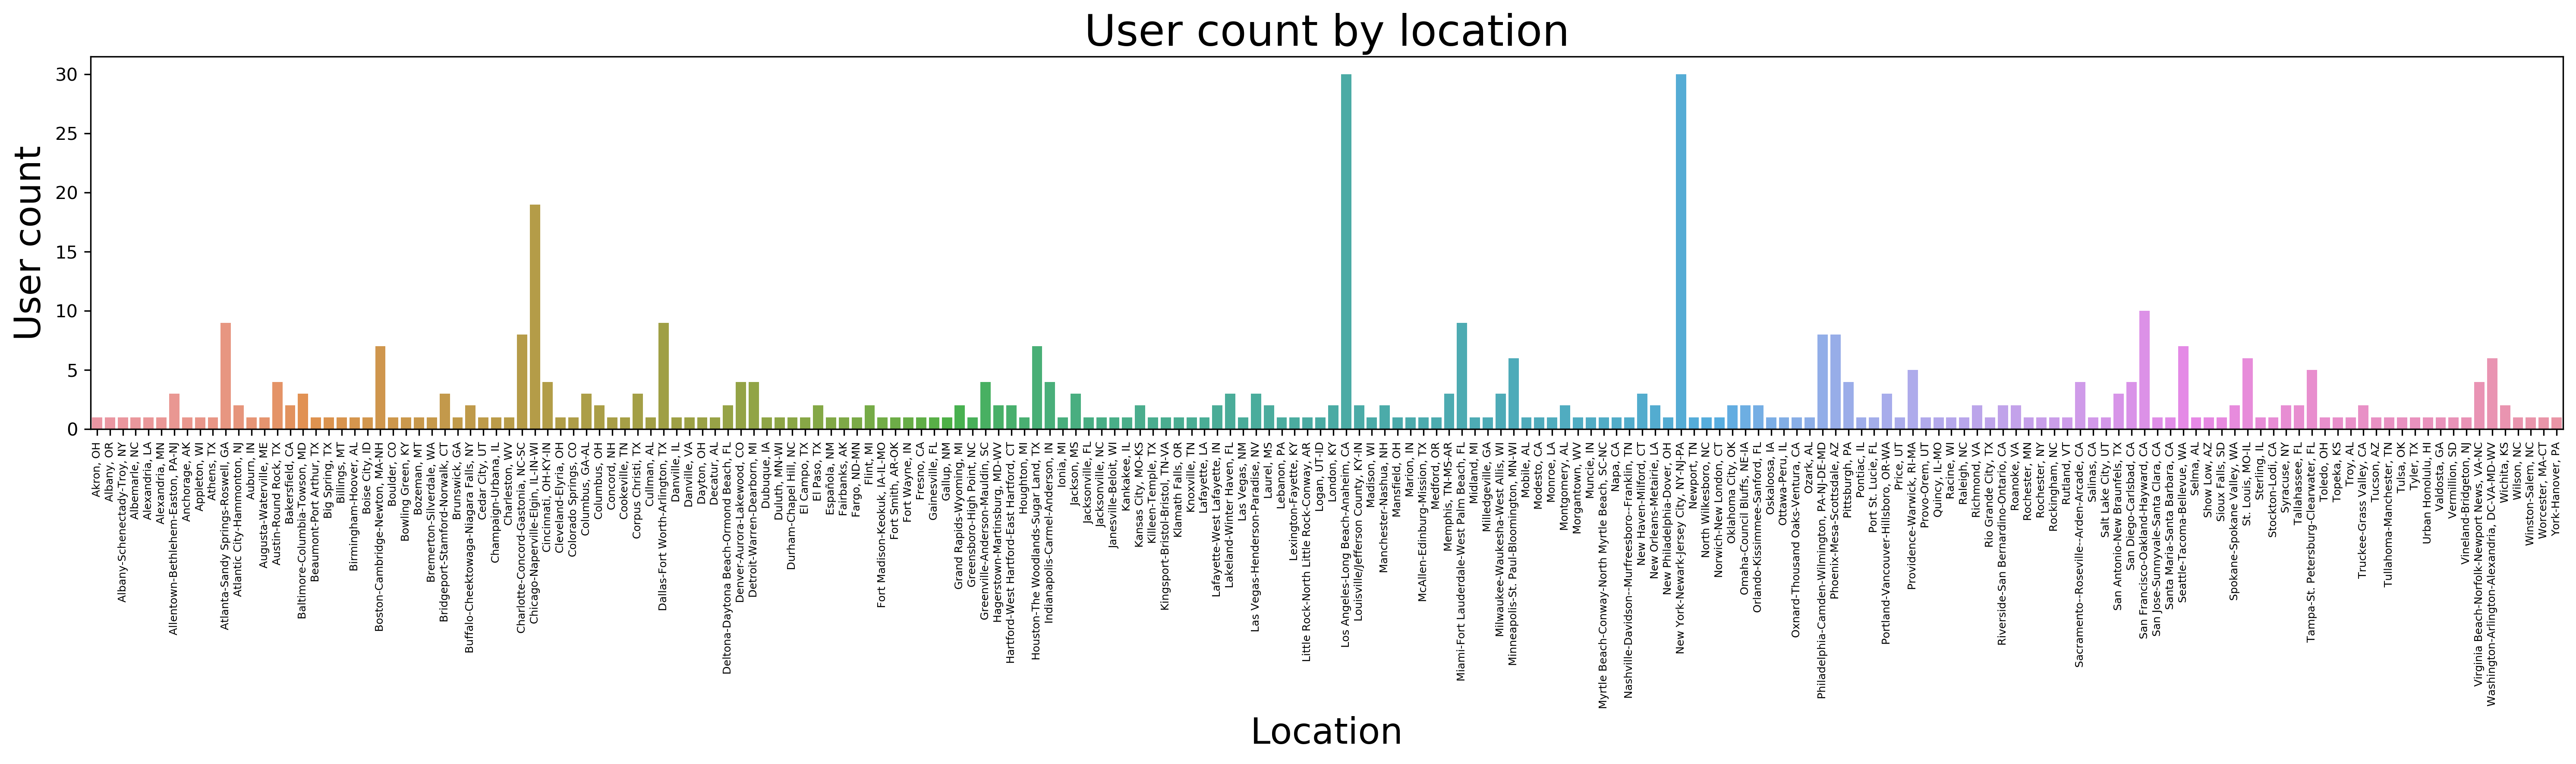

In [66]:
df_churned_location_pd = df_churn.dropDuplicates(["userId", "location"]).groupby(["location"]).count().sort("location").toPandas()
fig = plt.figure(figsize=(20, 6), dpi=300)
sns.barplot(x='location', y='count', data=df_churned_location_pd)
plt.title("User count by location", fontsize=24)
plt.xlabel("Location", fontsize=20)
plt.ylabel("User count", fontsize=20)
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.savefig("./plots/user_count_location.png")
plt.show()

### Investigation on the daily time-series perspective

In [56]:
# Get date column added to the df
daily_fn = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).date(), DateType())
df_churn_daily = df_churn.withColumn("date", daily_fn(df_churn.ts))

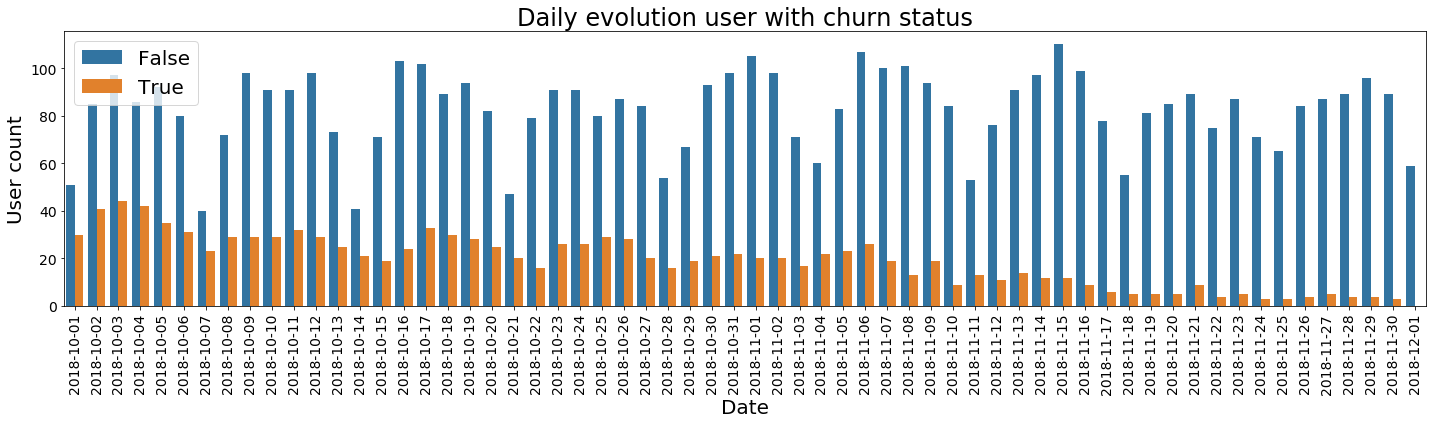

In [67]:
df_churned_daily_pd = df_churn_daily.dropDuplicates(["userId", "date"]).groupby(["date", "churn"]).count().sort("date").toPandas()
fig = plt.figure(figsize=(20, 6))
sns.barplot(x='date', y='count', hue='churn', data=df_churned_daily_pd)
plt.title("Daily evolution user with churn status", fontsize=24)
plt.xlabel("Date", fontsize=20)
plt.ylabel("User count", fontsize=20)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("./plots/user_daily_churn.png")
plt.show()

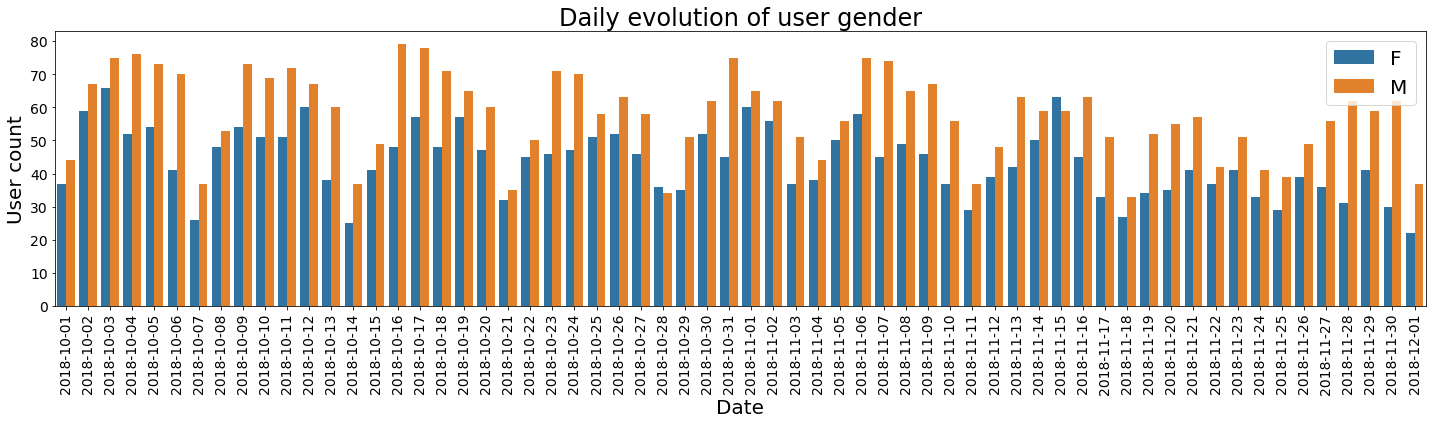

In [68]:
df_churned_daily_pd = df_churn_daily.dropDuplicates(["userId", "date"]).groupby(["date", "gender"]).count().sort("date").toPandas()
fig = plt.figure(figsize=(20, 6))
sns.barplot(x='date', y='count', hue='gender', data=df_churned_daily_pd)
plt.title("Daily evolution of user gender", fontsize=24)
plt.xlabel("Date", fontsize=20)
plt.ylabel("User count", fontsize=20)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("./plots/user_daily_gender.png")
plt.show()

#### Time evolution of user pay level

The plot shows like business is improving over the past one year with what looks like user conversion from free to paid, without churn and new users in the picture. 

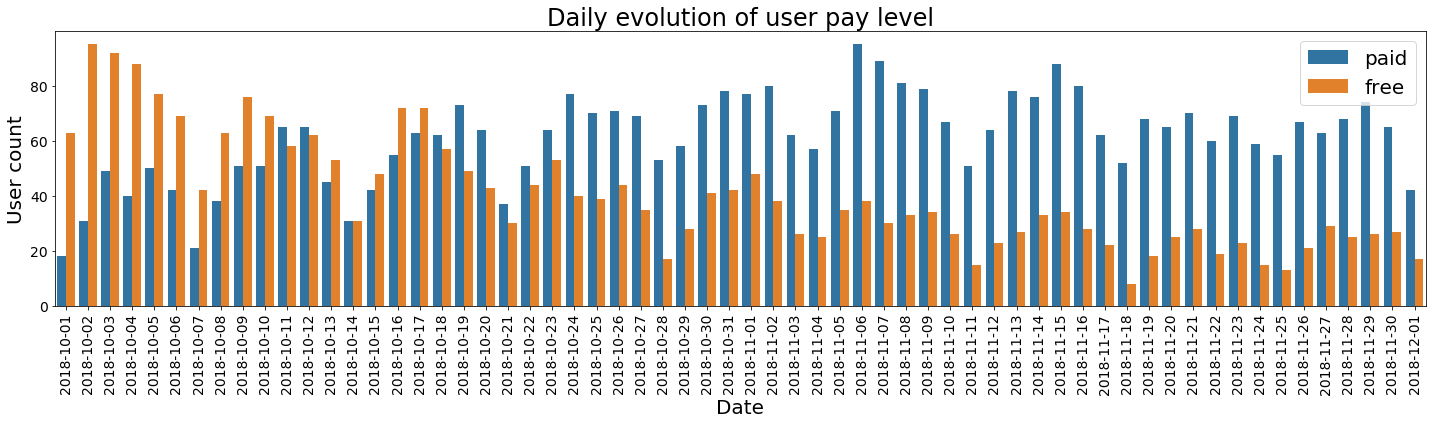

In [69]:
df_churned_daily_pd = df_churn_daily.dropDuplicates(["userId", "date"]).groupby(["date", "level"]).count().sort("date").toPandas()
fig = plt.figure(figsize=(20, 6))
sns.barplot(x='date', y='count', hue='level', data=df_churned_daily_pd)
plt.title("Daily evolution of user pay level", fontsize=24)
plt.xlabel("Date", fontsize=20)
plt.ylabel("User count", fontsize=20)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("./plots/user_daily_level.png")
plt.show()

#### Investigation on monthly perspective

There is not much utility here looking at the monthly data as we have only 2 month + of data here. It would be great to see a trend in development if we have at least 2 years of data. This could be done on the full dataset when computational resource allows. 

##### Flagging "Cancellation Confirmation"  as Churn. 

In [123]:
churn_events = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_cleaned = df_cleaned.withColumn("churn_flag", churn_events("page"))


In [124]:
# Calculate percentage of users who churned
churn_flag = df_cleaned.groupBy('userId').agg({'churn_flag': 'sum'})\
    .select(avg('sum(churn_flag)')).collect()[0]['avg(sum(churn_flag))']
print("{} % of users have churned by cancelling subscription.".format(round(churn_flag*100, 3)))

22.098 % of users have churned by cancelling subscription.


#### Number of cancellations

In [37]:
df_cleaned.filter(df_cleaned.page=="Cancellation Confirmation").select("userId").dropDuplicates().count()


99

#### Number of downgrades:

In [80]:
df_cleaned.filter(df_cleaned.page=="Submit Downgrade").select("userId").dropDuplicates().count()

97

In [86]:
downgrade_list = df_cleaned.filter(df_cleaned.page=="Submit Downgrade" ).select("userId").distinct()
downgraded_users = [(row['userId']) for row in downgrade_list.collect()]
df_downgrade = df_cleaned.withColumn("downgrade", df_cleaned.userId.isin(downgraded_users))
df_downgrade.dropDuplicates(["userId", "gender"]).groupby(["downgrade", "gender"]).count().sort("downgrade").show()

+---------+------+-----+
|downgrade|gender|count|
+---------+------+-----+
|    false|     F|  152|
|    false|     M|  199|
|     true|     M|   51|
|     true|     F|   46|
+---------+------+-----+



#### Number of upgrades:

In [82]:
df_cleaned.filter(df_cleaned.page=="Submit Upgrade").select("userId").dropDuplicates().count()

233

In [88]:
upgrade_list = df_cleaned.filter(df_cleaned.page=="Submit Upgrade" ).select("userId").distinct()
upgraded_users = [(row['userId']) for row in upgrade_list.collect()]
df_upgrade = df_cleaned.withColumn("upgrade", df_cleaned.userId.isin(upgraded_users))
df_upgrade.dropDuplicates(["userId", "gender"]).groupby(["upgrade", "gender"]).count().sort("upgrade").show()

+-------+------+-----+
|upgrade|gender|count|
+-------+------+-----+
|  false|     M|  120|
|  false|     F|   95|
|   true|     F|  103|
|   true|     M|  130|
+-------+------+-----+



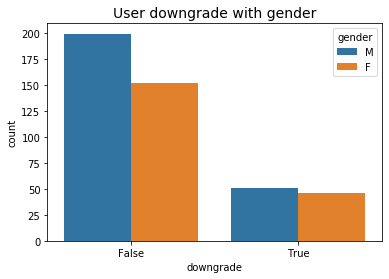

In [95]:
df_downgrade_pd = df_downgrade.dropDuplicates(["userId", "gender"]).groupby(["downgrade", "gender"]).count().sort("downgrade").toPandas()
sns.barplot(x='downgrade', y='count', hue='gender', data=df_downgrade_pd)
plt.title("User downgrade with gender", fontsize=14)
plt.savefig("./plots/user_gender_downgrade.png")
plt.show()

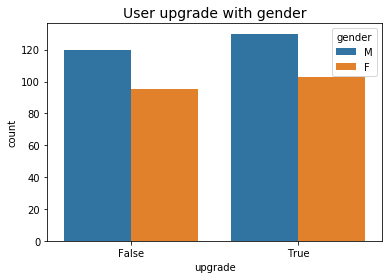

In [94]:
df_upgrade_pd = df_upgrade.dropDuplicates(["userId", "gender"]).groupby(["upgrade", "gender"]).count().sort("upgrade").toPandas()
sns.barplot(x='upgrade', y='count', hue='gender', data=df_upgrade_pd)
plt.title("User upgrade with gender", fontsize=14)
plt.savefig("./plots/user_gender_upgrade.png")
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

##### Gender (binary)

In [125]:
feat_gender = df_cleaned \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int')) \
    .orderBy("userId")
feat_gender.describe().show()

+-------+-----------------+------------------+
|summary|           userId|            gender|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|0.4419642857142857|
| stddev|105964.5842848519|0.4971756279079038|
|    min|               10|                 0|
|    max|               99|                 1|
+-------+-----------------+------------------+



In [126]:
feat_gender.select(skewness("gender"), kurtosis("gender")).show()

+-------------------+-------------------+
|   skewness(gender)|   kurtosis(gender)|
+-------------------+-------------------+
|0.23372261898725685|-1.9453737373737383|
+-------------------+-------------------+



##### Paid or Free (binary)

In [128]:
feat_level = df_cleaned \
    .select("userId", "level") \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'level') \
    .select('userId', col('level').cast('int')) \
    .orderBy("userId")
feat_level.describe().show()

+-------+------------------+------------------+
|summary|            userId|             level|
+-------+------------------+------------------+
|  count|               691|               691|
|   mean| 67259.47033285093|0.4645441389290883|
| stddev|106161.02506630082|0.4991025734716588|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [129]:
feat_level.select(skewness("level"), kurtosis("level")).show()

+-------------------+-------------------+
|    skewness(level)|    kurtosis(level)|
+-------------------+-------------------+
|0.14218137235745473|-1.9797844573545489|
+-------------------+-------------------+



##### Total number of songs listened

In [130]:
feat_song = df_cleaned \
              .select(["userId","song"]) \
              .groupby("userID") \
              .count()\
              .withColumnRenamed("count", "num_song") \
              .orderBy("userId")

feat_song.describe().show(5)

+-------+-----------------+------------------+
|summary|           userID|          num_song|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|1178.5825892857142|
| stddev|105964.5842848519|1380.6279647524054|
|    min|               10|                 3|
|    max|               99|              9767|
+-------+-----------------+------------------+



In [131]:
feat_song.select(skewness("num_song"), kurtosis("num_song")).show()

+------------------+------------------+
|skewness(num_song)|kurtosis(num_song)|
+------------------+------------------+
|2.2993135439060457| 6.814549363048505|
+------------------+------------------+



##### Total number of artist listened

In [132]:
# Number of artists listened
feat_artist = df_cleaned \
    .filter(df_cleaned.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_artist") \
    .orderBy("userId")

feat_artist.describe().show()

+-------+-----------------+-----------------+
|summary|           userId|       num_artist|
+-------+-----------------+-----------------+
|  count|              448|              448|
|   mean|67520.34821428571|658.9799107142857|
| stddev|105964.5842848519| 625.882698051957|
|    min|               10|                1|
|    max|               99|             3507|
+-------+-----------------+-----------------+



In [134]:
feat_artist.select(skewness("num_artist"), kurtosis("num_artist")).show()

+--------------------+--------------------+
|skewness(num_artist)|kurtosis(num_artist)|
+--------------------+--------------------+
|  1.4675037203781365|  2.2190317071776393|
+--------------------+--------------------+



##### Number of songs in playlist(s) added by user

In [135]:
feat_playlist = df_cleaned \
    .select('userID','page') \
    .where(df_cleaned.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_playlist_song') \
    .orderBy("userId")
feat_playlist.describe().show()

+-------+------------------+------------------+
|summary|            userID| num_playlist_song|
+-------+------------------+------------------+
|  count|               428|               428|
|   mean| 65764.93457943926|28.852803738317757|
| stddev|105363.38578382804|33.913090694566286|
|    min|                10|                 1|
|    max|                99|               248|
+-------+------------------+------------------+



In [136]:
feat_playlist.select(skewness("num_playlist_song"), kurtosis("num_playlist_song")).show()

+---------------------------+---------------------------+
|skewness(num_playlist_song)|kurtosis(num_playlist_song)|
+---------------------------+---------------------------+
|         2.4048605508981393|          7.736784413479519|
+---------------------------+---------------------------+



##### Number of friends added by user

In [138]:
feat_friends = df_cleaned \
    .select('userID','page') \
    .where(df_cleaned.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_friend') \
    .orderBy("userId")
feat_friends.describe().show()

+-------+------------------+------------------+
|summary|            userID|        num_friend|
+-------+------------------+------------------+
|  count|               409|               409|
|   mean|  66368.3716381418|19.772616136919314|
| stddev|106064.01609030597| 22.49443576627283|
|    min|                10|                 1|
|    max|                99|               158|
+-------+------------------+------------------+



In [139]:
feat_friends.select(skewness("num_friend"), kurtosis("num_friend")).show()

+--------------------+--------------------+
|skewness(num_friend)|kurtosis(num_friend)|
+--------------------+--------------------+
|  2.4002649609428586|   7.678714779071942|
+--------------------+--------------------+



##### Total length of listening time

In [140]:
feat_listentime = df_cleaned \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'time_listen') \
    .orderBy("userId")
feat_listentime.describe().show()

+-------+-----------------+------------------+
|summary|           userID|       time_listen|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|240270.49760906256|
| stddev|105964.5842848519|  286257.952604531|
|    min|               10|         131.00363|
|    max|               99|     2019435.10394|
+-------+-----------------+------------------+



In [141]:
feat_listentime.select(skewness("time_listen"), kurtosis("time_listen")).show()

+---------------------+---------------------+
|skewness(time_listen)|kurtosis(time_listen)|
+---------------------+---------------------+
|    2.303088337172893|    6.791766280616427|
+---------------------+---------------------+



##### Average number of songs per session

In [142]:
feat_avgsongs = df_cleaned.filter(df_cleaned.page =="NextSong") \
                               .groupBy(["userId", "sessionId"]) \
                               .count() \
                               .groupby(['userId']) \
                               .agg({'count':'avg'}) \
                               .withColumnRenamed('avg(count)', 'avg_songs') \
                               .orderBy("userId")

feat_avgsongs.describe().show()

+-------+-----------------+-----------------+
|summary|           userId|        avg_songs|
+-------+-----------------+-----------------+
|  count|              448|              448|
|   mean|67520.34821428571|65.61168409976814|
| stddev|105964.5842848519|39.49496566617267|
|    min|               10|              1.0|
|    max|               99|            360.0|
+-------+-----------------+-----------------+



In [143]:
feat_avgsongs.select(skewness("avg_songs"), kurtosis("avg_songs")).show()

+-------------------+-------------------+
|skewness(avg_songs)|kurtosis(avg_songs)|
+-------------------+-------------------+
| 1.5731533253340253|  6.713093146603137|
+-------------------+-------------------+



##### Average time per session

In [144]:
feat_sesstime = df_cleaned.groupBy(["userId", "sessionId"]) \
                .agg(((max_fn(df_cleaned.ts)-min_fn(df_cleaned.ts))/(1000*60))
                .alias("sessTime"))
feat_avgtime = feat_sesstime.groupby("userId") \
                    .agg(avg(feat_sesstime.sessTime).alias("avgSessTime")) \
                    .orderBy("userId")

feat_avgtime.describe().show()


+-------+-----------------+------------------+
|summary|           userId|       avgSessTime|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|   267.78884543676|
| stddev|105964.5842848519| 164.3624010530248|
|    min|               10|13.166666666666666|
|    max|               99|            1502.4|
+-------+-----------------+------------------+



In [145]:
feat_avgtime.select(skewness("avgSessTime"), kurtosis("avgSessTime")).show()

+---------------------+---------------------+
|skewness(avgSessTime)|kurtosis(avgSessTime)|
+---------------------+---------------------+
|   1.6431669833905285|    7.153986718436954|
+---------------------+---------------------+



In [17]:
feat_avgtime.show(5)

+------+------------------+
|userId|       avgSessTime|
+------+------------------+
|    10|            1502.4|
|   100|350.47777777777776|
|100001|137.66111111111113|
|100002|          150.2625|
|100003|296.92777777777775|
+------+------------------+
only showing top 5 rows



##### Number of session per user

In [147]:
feat_session = df_cleaned.select("userId", "sessionId") \
                .dropDuplicates() \
                .groupby("userId") \
                .count() \
                .withColumnRenamed('count', 'session') \
                .orderBy("userId")
feat_session.describe().show()

+-------+-----------------+------------------+
|summary|           userId|           session|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|13.571428571428571|
| stddev|105964.5842848519| 13.17102391180226|
|    min|               10|                 1|
|    max|               99|                92|
+-------+-----------------+------------------+



In [148]:
feat_session.select(skewness("session"), kurtosis("session")).show()

+------------------+-----------------+
| skewness(session)|kurtosis(session)|
+------------------+-----------------+
|2.3492597105561734|7.726622405284306|
+------------------+-----------------+



##### Label (churn)

In [149]:
# label user who churned using the churn_flag defined earlier. 
user_partitions = Window.partitionBy('userId')
df_cleaned = df_cleaned.withColumn('churn', max('churn_flag').over(user_partitions))
label = df_cleaned \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates() \
    .orderBy("userId")
label.describe().show()

+-------+-----------------+-------------------+
|summary|           userId|              label|
+-------+-----------------+-------------------+
|  count|              448|                448|
|   mean|67520.34821428571|0.22098214285714285|
| stddev|105964.5842848519| 0.4153723104396363|
|    min|               10|                  0|
|    max|               99|                  1|
+-------+-----------------+-------------------+



In [150]:
label.select(skewness("label"), kurtosis("label")).show()

+------------------+--------------------+
|   skewness(label)|     kurtosis(label)|
+------------------+--------------------+
|1.3449610206355533|-0.19107985297097096|
+------------------+--------------------+



In [152]:
# Construct dataset
dataset = feat_gender.join(feat_level,'userID','outer') \
    .join(feat_song,'userID','outer') \
    .join(feat_artist,'userID','outer') \
    .join(feat_playlist,'userID','outer') \
    .join(feat_friends,'userID','outer') \
    .join(feat_listentime,'userID','outer') \
    .join(feat_avgsongs,'userID','outer') \
    .join(feat_avgtime,'userID','outer') \
    .join(feat_session,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

dataset.show(5)

+------+-----+--------+----------+-----------------+----------+------------------+---------+------------------+-------+-----+
|gender|level|num_song|num_artist|num_playlist_song|num_friend|       time_listen|avg_songs|       avgSessTime|session|label|
+------+-----+--------+----------+-----------------+----------+------------------+---------+------------------+-------+-----+
|     1|    0|     137|        94|                1|         3|25870.950739999997|     48.0|           210.375|      2|    1|
|     0|    0|     395|       287|                6|         2| 78695.82684000001|     62.0|263.06000000000006|      5|    1|
|     0|    1|     395|       287|                6|         2| 78695.82684000001|     62.0|263.06000000000006|      5|    1|
|     1|    1|     152|       108|                3|         2|28314.150060000007|     22.4| 97.03666666666666|      5|    1|
|     1|    0|     152|       108|                3|         2|28314.150060000007|     22.4| 97.03666666666666|      5

In [154]:
dataset.head(5)

[Row(gender=1, level=0, num_song=137, num_artist=94, num_playlist_song=1, num_friend=3, time_listen=25870.950739999997, avg_songs=48.0, avgSessTime=210.375, session=2, label=1),
 Row(gender=0, level=0, num_song=395, num_artist=287, num_playlist_song=6, num_friend=2, time_listen=78695.82684000001, avg_songs=62.0, avgSessTime=263.06000000000006, session=5, label=1),
 Row(gender=0, level=1, num_song=395, num_artist=287, num_playlist_song=6, num_friend=2, time_listen=78695.82684000001, avg_songs=62.0, avgSessTime=263.06000000000006, session=5, label=1),
 Row(gender=1, level=1, num_song=152, num_artist=108, num_playlist_song=3, num_friend=2, time_listen=28314.150060000007, avg_songs=22.4, avgSessTime=97.03666666666666, session=5, label=1),
 Row(gender=1, level=0, num_song=152, num_artist=108, num_playlist_song=3, num_friend=2, time_listen=28314.150060000007, avg_songs=22.4, avgSessTime=97.03666666666666, session=5, label=1)]

In [485]:
filepath = "sparkify_dataset.csv"

In [483]:
dataset.toPandas().to_csv(filepath)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [486]:
# Jump straight to pre-saved file loading without having to go through data pre-processing and featur engineering.
dataset = spark.read.csv(filepath, header=True)
dataset.show(5)

+---+------+-----+--------+----------+-----------------+----------+------------------+---------+------------------+-------+-----+
|_c0|gender|level|num_song|num_artist|num_playlist_song|num_friend|       time_listen|avg_songs|       avgSessTime|session|label|
+---+------+-----+--------+----------+-----------------+----------+------------------+---------+------------------+-------+-----+
|  0|     1|    0|     137|        94|                1|         3|25870.950739999997|     48.0|           210.375|      2|    1|
|  1|     0|    0|     395|       287|                6|         2| 78695.82684000001|     62.0|263.06000000000006|      5|    1|
|  2|     0|    1|     395|       287|                6|         2| 78695.82684000001|     62.0|263.06000000000006|      5|    1|
|  3|     1|    1|     152|       108|                3|         2|28314.150060000007|     22.4| 97.03666666666666|      5|    1|
|  4|     1|    0|     152|       108|                3|         2|28314.150060000007|    

##### Features

In [155]:
type(dataset)

pyspark.sql.dataframe.DataFrame

##### Labels

In [481]:
dataset.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  157|
|    0|  534|
+-----+-----+



##### Vector assembler

In [162]:
cols = dataset.columns[:-1]
assembler = VectorAssembler(inputCols=cols, outputCol="NumericFeatures")
data = assembler.transform(dataset)
data

DataFrame[gender: int, level: int, num_song: bigint, num_artist: bigint, num_playlist_song: bigint, num_friend: bigint, time_listen: double, avg_songs: double, avgSessTime: double, session: bigint, label: int, NumericFeatures: vector]

##### Standard scaler

In [163]:
std_scaler = StandardScaler(inputCol="NumericFeatures", outputCol="features", withStd=True)
scalerModel = std_scaler.fit(data)
data = scalerModel.transform(data)

In [164]:
# Train test split
train, test = data.randomSplit([0.8, 0.2], seed=36)

#### Metric selection

Due to label and partial feature data skewness, all recall, precision, accuracy and F1 scores are taken into consideration. F1 is the main metric taken into consideration since it has all true positive, true negative, false positive, false negative taken into consideration. 
And as such is a more balanced metric. A model that simply label all data points as non-churn (we have 22% churn labels as true positive) would achieve 78% accuracy rate but would not get a passing F1 score. 

In [165]:
def eval_model(model, data):
    """
    Evaluate a learned model given an unseen dataset
    """
    pred = model.transform(data)
   
    evaluator = MulticlassClassificationEvaluator()
        
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
   
    # Build a Spark dataframe from the metrics
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return summary


#### A visualization on feature importance 

To investigate if some features are worth keeping. 
A point to note is that feature correlation has not been taken into account.

In [166]:
def plot_feature_importance(model, feature_cols, clf):
    """
    Plot bar chart showing the importance of features with given model. 
    """
    
    if clf == 'LogisticRegression':    
        feature_coef = model.coefficients.values.tolist()
        feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
        .sort_values('Coefficient', ascending=False)
    else:        
        feature_ind = model.featureImportances.indices.tolist()
        feature_name = [feature_cols[ind] for ind in feature_ind]
        feature_coef = model.featureImportances.values.tolist()
        feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for {}'.format(clf), fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig('feature_importance_{}.png'.format(clf))
    plt.show()

#### Classifers adopted for model identification. 

Four classifiers are selected with pools of parameters to perform grid search with 3-fold crosss validation. 

In [167]:
lr =  LogisticRegression(labelCol="label", featuresCol="features")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid_dt = ParamGridBuilder()\
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 4, 6, 8]) \
    .build()

gbt = GBTClassifier(labelCol="label", featuresCol="features")
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxIter,[10, 20, 30])\
    .addGrid(gbt.maxBins, [20, 40, 60])\
    .addGrid(gbt.maxDepth,[2, 4, 6, 8, 10]) \
    .build()

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .build()

estimator_name = ['LogisticRegression', 'DecisionTreeClassifier', 'GBTClassifier', 'RandomForestClassifier' ]
estimator_model = [LogisticRegressionModel, DecisionTreeClassificationModel, GBTClassificationModel, RandomForestClassificationModel]
estimators = [lr, dt, gbt, rf]
paramGrids = [paramGrid_lr, paramGrid_dt, paramGrid_gbt, paramGrid_rf]

In [175]:
paramGrid_lr_n = ParamGridBuilder().build()
paramGrid_dt_n = ParamGridBuilder().build()
paramGrid_gbt_n = ParamGridBuilder().build()
paramGrid_rf_n = ParamGridBuilder().build()

paramGrids_n = [paramGrid_lr_n, paramGrid_dt_n, paramGrid_gbt_n, paramGrid_rf_n]

In [173]:
def train_model(train, estimator, paramGrid, folds=3):
    """
    Fit an estimator with training data and tune it with the defined parameter grid using 3-folds cross validation
    """
    crossval = CrossValidator(estimator=estimator,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=folds)
    model = crossval.fit(train)
    
    return model

def train_model_n(train, estimator, folds=3):
    """
    Fit an estimator with training data and tune it with the defined parameter grid using 3-folds cross validation
    """
    crossval = CrossValidator(estimator=estimator,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=folds)
    model = crossval.fit(train)
    
    return model

### Hyper-parameter Tuning

The following are hyper-parameters used for grid search in the ML pipeline. Another pipeline without the range of hyperparameters is also used to compare training performance. 
<br />
1. Linear Regression <br />
elasticNetParam: 0.0, 0.1, 0.5, 1.0<br />
regParam: 0.0, 0.05, 0.1<br />
<br />
2. Decision Tree<br />
impurity: entropy, gini<br />
maxDepth: 2, 4, 6, 8<br />
<br />
3. Gradient Boosting Classifier<br />
maxIter: 10, 20, 3<br />
maxBins: 20, 40, 60<br />
maxDepth: 2, 4, 6, 8, 10<br />
<br />
4. Random Forest<br />
impurity: entropy, gini<br />
maxDepth: 2, 4, 6, 8<br />

### Modelling without grid search of hyperparameters

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning LogisticRegression model >
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.6684|0.7606|0.6753|  0.7606|
+---------+------+------+--------+

Training time 10.31 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.LogisticRegressionModel'> 2 LogisticRegression


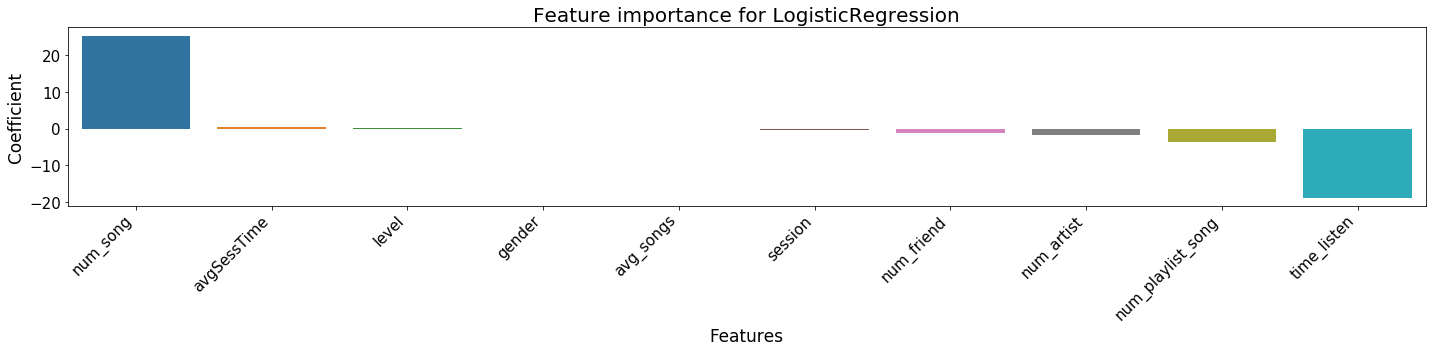

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning DecisionTreeClassifier model >
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.7355|0.7746|0.7134|  0.7746|
+---------+------+------+--------+

Training time 8.49 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.DecisionTreeClassificationModel'> 2 DecisionTreeClassifier


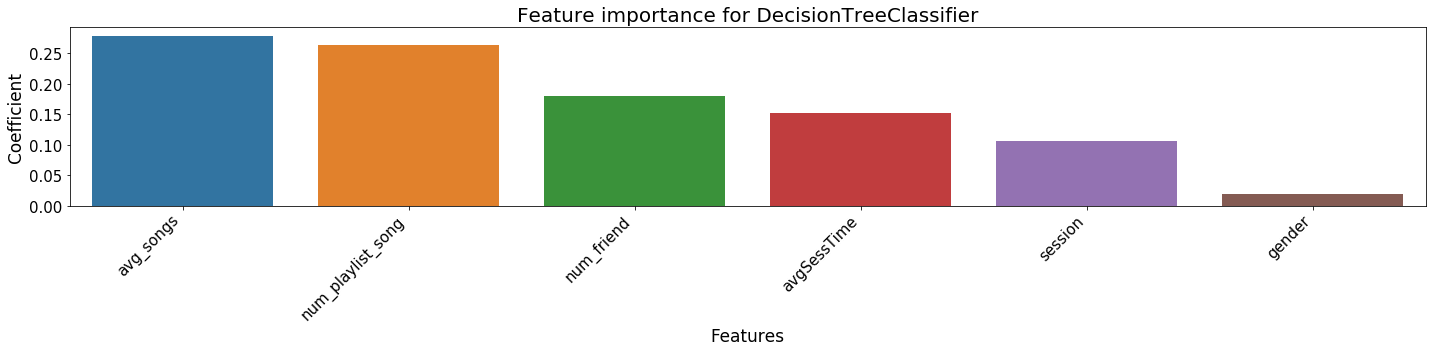

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning GBTClassifier model >
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.8346| 0.838|0.8158|   0.838|
+---------+------+------+--------+

Training time 11.74 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.GBTClassificationModel'> 2 GBTClassifier


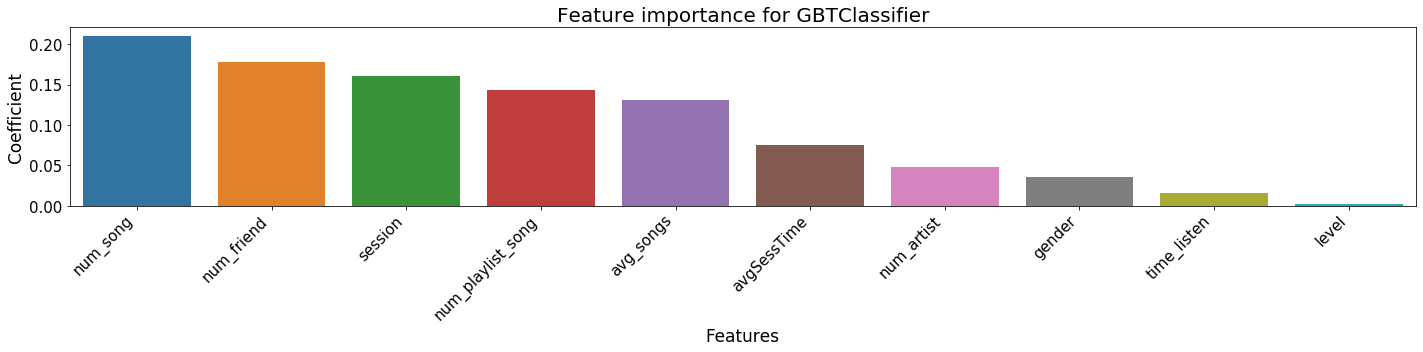

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning RandomForestClassifier model >
Evaluation result:
+---------+------+-----+--------+
|precision|recall|   f1|accuracy|
+---------+------+-----+--------+
|   0.8258|0.7746|0.683|  0.7746|
+---------+------+-----+--------+

Training time 9.23 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.RandomForestClassificationModel'> 2 RandomForestClassifier


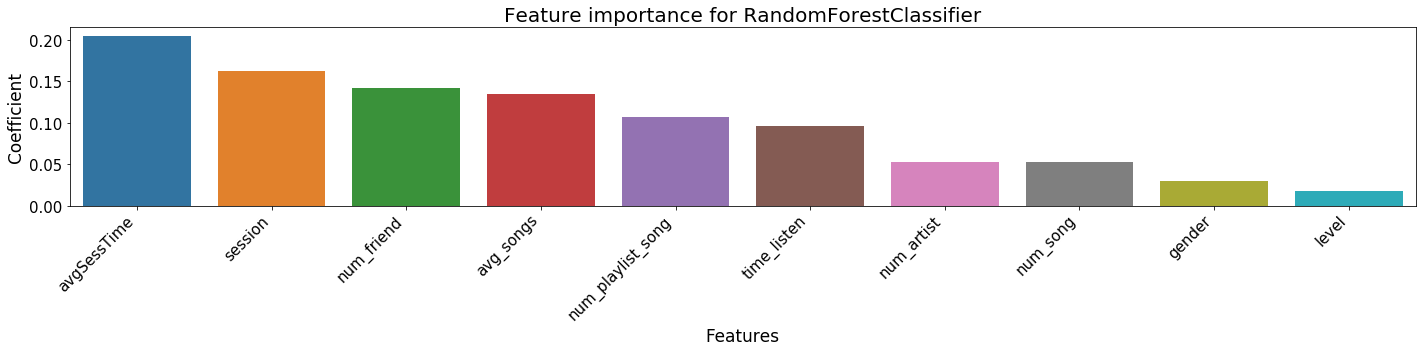

In [176]:
##### Modelling classifiers
for i, est in enumerate(estimators):
    print("{}{}".format("≤"*50,"≥"*50))
    start = time()
    print("Training & tuning {} model >".format(estimator_name[i]))
    model_n = train_model(train, est, paramGrids_n[i])
    end = time()
    summary_n = eval_model(model_n, test)
    print("Evaluation result:")
    summary_n.show()
    end = time()
    print('Training time {} minutes'.format(round((end - start)/60,2)))
    print('Plotting feature importance now ...')
    model_n.bestModel.write().overwrite().save(estimator_name[i])
    print("1:", estimator_model[i], "2", estimator_name[i])
    best_model_n = estimator_model[i].load(estimator_name[i])
    plot_feature_importance(best_model_n, dataset.columns[:-1], estimator_name[i])
    print("{}".format("="*91))

### Modelling with grid search of hyperparameters

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning LogisticRegression model >
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.6684|0.7606|0.6753|  0.7606|
+---------+------+------+--------+

Training time 19.93 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.LogisticRegressionModel'> 2 LogisticRegression


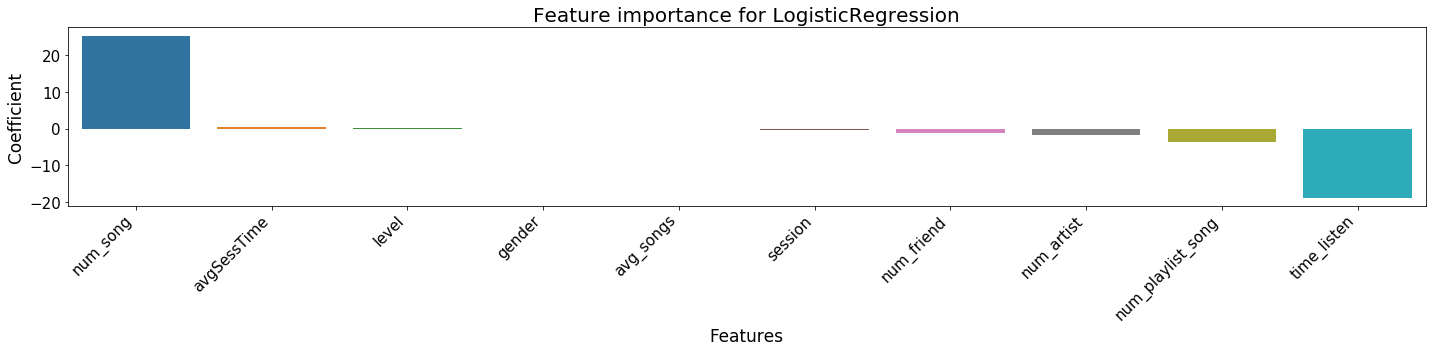

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning DecisionTreeClassifier model >
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|    0.738|0.7746|0.7351|  0.7746|
+---------+------+------+--------+

Training time 11.05 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.DecisionTreeClassificationModel'> 2 DecisionTreeClassifier


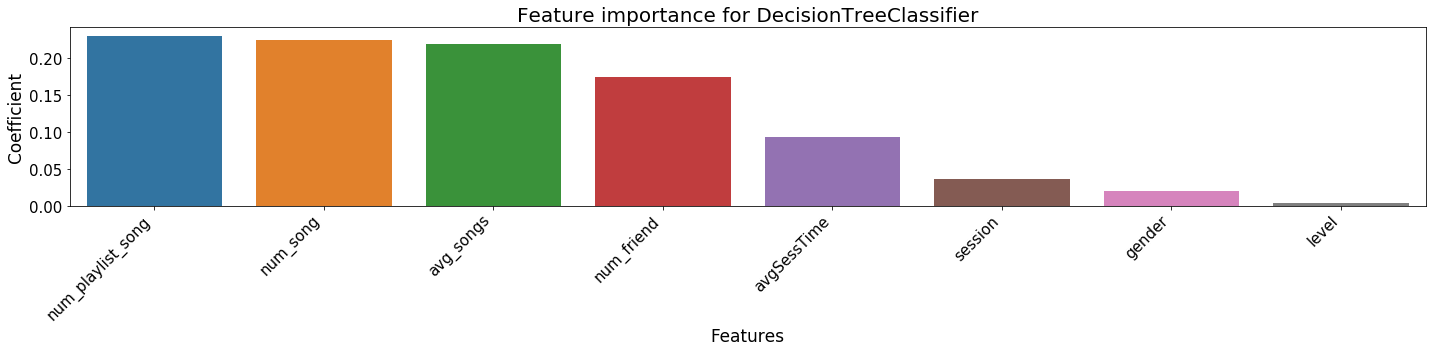

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning GBTClassifier model >
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.8611|0.8662|0.8622|  0.8662|
+---------+------+------+--------+

Training time 187.47 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.GBTClassificationModel'> 2 GBTClassifier


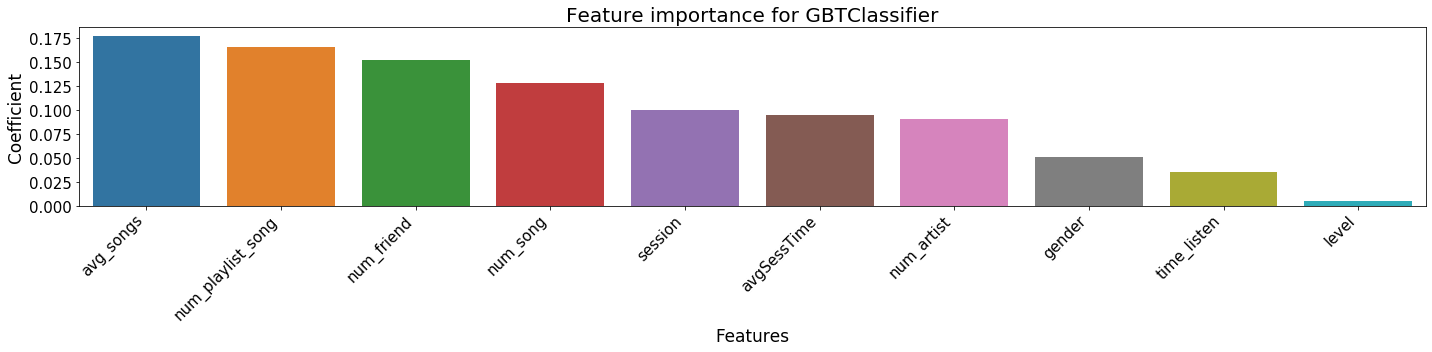

≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≤≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥
Training & tuning RandomForestClassifier model >
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.8387|0.7958|0.7277|  0.7958|
+---------+------+------+--------+

Training time 11.36 minutes
Plotting feature importance now ...
1: <class 'pyspark.ml.classification.RandomForestClassificationModel'> 2 RandomForestClassifier


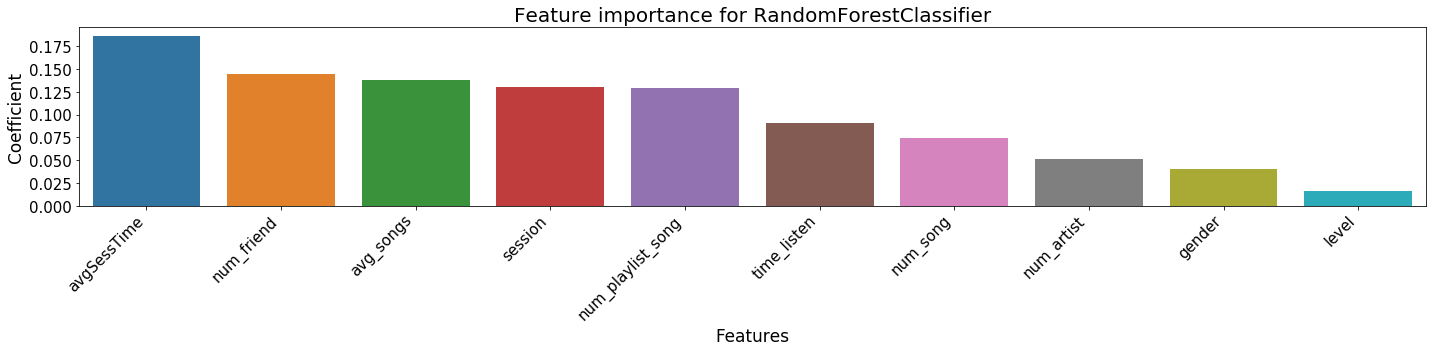

In [97]:
##### Modelling classifiers
for i, est in enumerate(estimators):
    print("{}{}".format("≤"*50,"≥"*50))
    start = time()
    print("Training & tuning {} model >".format(estimator_name[i]))
    model = train_model(train, est, paramGrids[i])
    end = time()
    summary = eval_model(model, test)
    print("Evaluation result:")
    summary.show()
    end = time()
    print('Training time {} minutes'.format(round((end - start)/60,2)))
    print('Plotting feature importance now ...')
    model.bestModel.write().overwrite().save(estimator_name[i])
    print("1:", estimator_model[i], "2", estimator_name[i])
    best_model = estimator_model[i].load(estimator_name[i])
    plot_feature_importance(best_model, dataset.columns[:-1], estimator_name[i])
    print("{}".format("="*91))

### Hyper-parameter tuning

For a quick look at hyper-parameter with and without tuning comparison, the modelling evaluation results above shows that the trade-off between model performance and computational resources is mixed for the four classifiers experimented. We save almost half of the Logistic regression training time without grid search for no difference in model performance improvement. For GradientBoosting Tree (GBT)the performance improvement with grid search is substantial: F1 score of 0.8622 (with grid search) vs 0.8158. However the computation time took almost 3 hours more with grid search. GBT is certainly a high computation complexity algorithm that increases exponentially with larger dataset. Grid search was done on a 240Mb dataset, imagine if we grid search on a 12Gb dataset! 

In comparison, Decision Tree and Random Forest's grid search and computation trade off is more linear, a minor performance improvement with minor increase in computation requirement. As such by knowing the learning algorithm computation complexity, we can make wiser decision when it comes to performance vs computation trade off.

All in all, the best performing model sfter grid searching is GBTClassifier, let see what are the hyper-parameter used: 

In [33]:
best_model = GBTClassificationModel.load('GBTClassifier')

In [36]:
best_model._java_obj.getMaxDepth()


8

In [34]:
best_model._java_obj.getMaxIter()

30

In [35]:
best_model._java_obj.getMaxBins()

40

Gradient boosting tree classifier produces the best f1 score. Assuming the full dataset shares the same characteristics as the tiny dataset, this model will be adopted to train a more holistic churn prediction model using the full dataset. With regards to features, although features are not equally important for every features, all 10 engieered features will be adopted to ensure model robustness since all ten contributes to learning. 

## Conclusion

On hindsight, I could have made a mixed of right and wrong decisions when it comes to assumption made on the large dataset: what features to engineer, what model and hyper-parameter to use for training. As such there should be rooms for improvement for a better trained big data predictive model that yield more promising evaluation metrics with minimum computation time and resources. Among these are: 
More data exploration and experimentation and on local machine to get a refined modelling approach on the large dataset. 
There are at least statistical differences in the large dataset, hyper-parameter tuning is still necessary. Adopt randomised search instead grid-search. 
Test for collinearity among the engineered features, remove the collinear features to save on computational resources

For research beyond this project, aside from churn prediction, the dataset can be useful to identify more factors that cause and if not improve the promising trends shown in the daily evolution plots.

